In [270]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin

import isodate
import pickle
from sklearn.model_selection import train_test_split
from ast import literal_eval
from imblearn.pipeline import Pipeline as ImbPipeline

#importing models
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

print("import complete")

import complete


Import the dataset, please modify the path to dataset based on your local directory

In [220]:
data = pd.read_csv("C:\\all_necessary_video_data.csv")

Examine the imbalance of the dataset

In [217]:
print(data['isTrending'].value_counts())

isTrending
0    14131
1      651
Name: count, dtype: int64


In [108]:
data.head()

,publishedAt,elapsedDays,title,channelTitle,category,topicCategories,duration,licensedContent,viewCount,likeCount,commentCount,avgDailyViews,engagementRate,isTrending
0,2024-10-18T04:00:07Z,54.4286,ROSÉ & Bruno Mars - APT. (Official Music Video),ROSÉ,Music,"['Music', 'Pop music']",PT2M54S,True,553630683,10791998,484175,10171687.00,0.02040,1
1,2024-12-10T08:00:06Z,0.8621,28 YEARS LATER – Official Trailer (HD),Sony Pictures Entertainment,Entertainment,"['Entertainment', 'Film']",PT2M13S,True,6924910,290068,24004,8032606.43,0.04535,1
2,2024-12-06T05:00:06Z,5.3869,ROSÉ - toxic till the end (official music video),ROSÉ,Music,"['Music', 'Pop music']",PT3M54S,True,34433972,1660914,74908,6392168.41,0.05040,1
3,2024-12-08T16:00:08Z,2.9574,TOY STORY IN BRAWL STARS!?,Brawl Stars,Gaming,"['Action game', 'Video game culture']",PT8M20S,True,13747073,568795,58895,4648364.44,0.04570,1
4,2024-10-18T15:00:46Z,53.9698,excited to see what shorts ideas y’all come up...,ROSÉ,People & Blogs,"['Fashion', 'Lifestyle (sociology)']",PT28S,False,214429941,6618423,59532,3973146.85,0.03110,1


Data preprocessing for models

Converting the string representations of list into actual Python lists

In [221]:
data['topicCategories'].head()

0                   ['Music', 'Pop music']
1                ['Entertainment', 'Film']
2                   ['Music', 'Pop music']
3    ['Action game', 'Video game culture']
4     ['Fashion', 'Lifestyle (sociology)']
Name: topicCategories, dtype: object

In [222]:
def process_topic_categories(topic_str):
    topics = literal_eval(topic_str)  # Convert string to list
    return topics

data['topicCategories'] = data['topicCategories'].apply(process_topic_categories)

In [223]:
data['topicCategories'].head()

0                   [Music, Pop music]
1                [Entertainment, Film]
2                   [Music, Pop music]
3    [Action game, Video game culture]
4     [Fashion, Lifestyle (sociology)]
Name: topicCategories, dtype: object

We examine the distribution of numerical values to see if they need further work

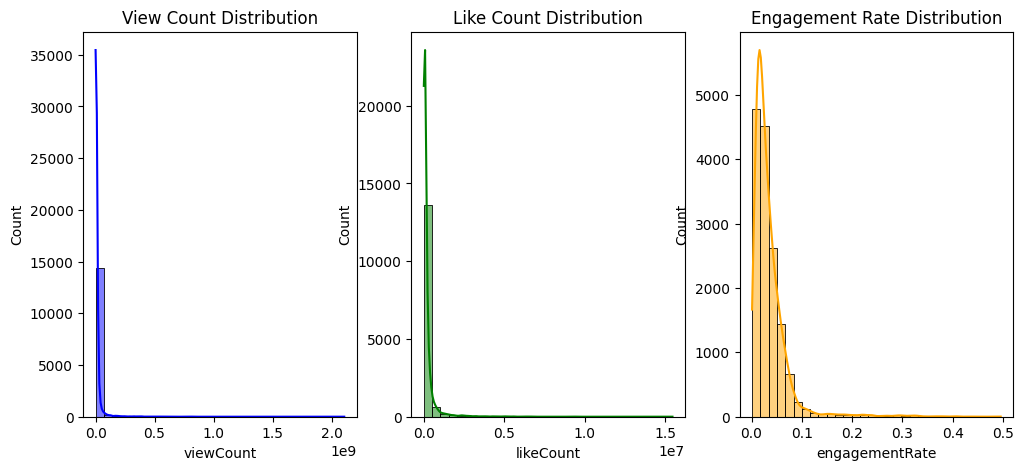

In [ ]:
# Plot histograms for viewCount and likeCount
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
sns.histplot(data['viewCount'], bins=30, kde=True, color='blue')
plt.title("View Count Distribution")

plt.subplot(1, 3, 2)
sns.histplot(data['likeCount'], bins=30, kde=True, color='green')
plt.title("Like Count Distribution")

plt.subplot(1,3,3)
sns.histplot(data['engagementRate'], bins=30, kde=True, color='orange')
plt.title("Engagement Rate Distribution")

plt.show()


In [154]:
from scipy.stats import skew

view_count_skew = skew(data['viewCount'])
like_count_skew = skew(data['likeCount'])
comment_count_skew = skew(data['commentCount'])
topicWeightSum_skew = skew(data['topicWeightSum'])
engagementrate_skew = skew(data['engagementRate'])
avgdailyviews_skew = skew(data['avgDailyViews'])

print(f"View Count Skewness: {view_count_skew}")
print(f"Like Count Skewness: {like_count_skew}")
print(f"Comment Count Skewness: {comment_count_skew}")
print(f"topicWeightSum Skewness: {topicWeightSum_skew}")
print(f"Engagementrate Skewness: {engagementrate_skew}")
print(f"Average Daily views skew:{avgdailyviews_skew}")

View Count Skewness: 15.576835434438767
Like Count Skewness: 8.68858396121573
Comment Count Skewness: 27.41003505842304
topicWeightSum Skewness: 0.7895226875665718
Engagementrate Skewness: 4.602990111067877
Average Daily views skew:31.5094404706115


In [156]:
print(data[['viewCount', 'likeCount','commentCount','engagementRate','avgDailyViews']].describe())

          viewCount     likeCount  commentCount  engagementRate  avgDailyViews
count  1.478200e+04  1.478200e+04  1.478200e+04    14782.000000   1.478200e+04
mean   1.328207e+07  2.132781e+05  9.962182e+03        0.035234   2.661235e+04
std    6.073794e+07  5.831684e+05  5.381115e+04        0.038039   1.688567e+05
min    9.023300e+04  2.360000e+03  7.000000e+01        0.001000   1.700800e+02
25%    9.522305e+05  2.561600e+04  8.740000e+02        0.014700   1.250705e+03
50%    2.823710e+06  6.388200e+04  2.487000e+03        0.025700   3.657180e+03
75%    8.445217e+06  1.716235e+05  7.074750e+03        0.043800   1.083912e+04
max    2.107863e+09  1.544242e+07  2.738497e+06        0.495600   1.017169e+07


As we seen above, the skewness of some numerical data is quiet high, some is extremely high, while the mean, count and standard deivation of some is also alarming.

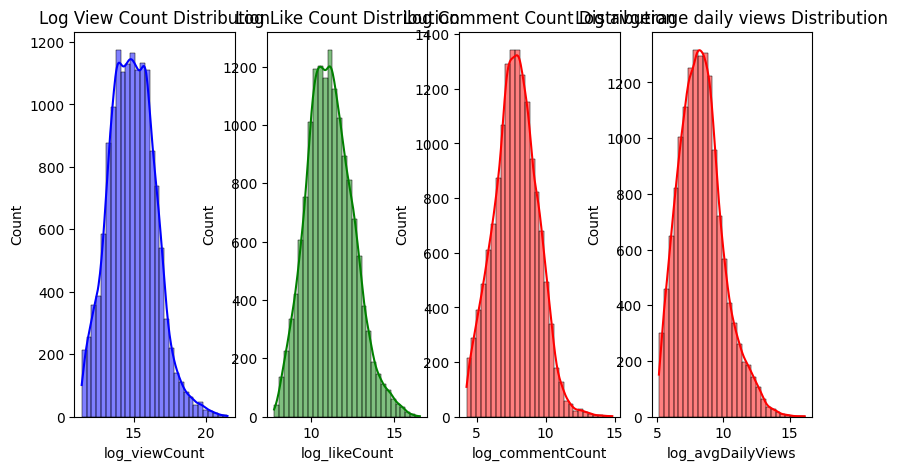

Log View Count Skewness: 0.3130156080900953
Log Like Count Skewness: 0.359943977576499
Log Comment Count Skewness: 0.14568073549387994
Log average daily views Skewness: 0.6017598854861479


In [242]:
data['log_viewCount'] = np.log1p(data['viewCount'])  # Use log1p to handle zero values
data['log_likeCount'] = np.log1p(data['likeCount'])
data['log_commentCount'] = np.log1p(data['commentCount'])
#data['log_engagmentRate'] = np.log1p(data['engagementRate'])
data['log_avgDailyViews'] = np.log1p(data['avgDailyViews'])

# Recheck distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 5, 1)
sns.histplot(data['log_viewCount'], bins=30, kde=True, color='blue')
plt.title("Log View Count Distribution")

plt.subplot(1, 5, 2)
sns.histplot(data['log_likeCount'], bins=30, kde=True, color='green')
plt.title("Log Like Count Distribution")

plt.subplot(1, 5, 3)
sns.histplot(data['log_commentCount'], bins=30, kde=True, color='red')
plt.title("Log Comment Count Distribution")

#plt.subplot(1, 5, 5)
#sns.histplot(data['log_engagmentRate'], bins=30, kde=True, color='red')
#plt.title("Log Engagement Rate Distribution")

plt.subplot(1, 5, 4)
sns.histplot(data['log_avgDailyViews'], bins=30, kde=True, color='red')
plt.title("Log avgerage daily views Distribution")

plt.show()

# Recheck skewness
log_view_count_skew = skew(data['log_viewCount'])
log_like_count_skew = skew(data['log_likeCount'])
log_comment_count_skew = skew(data['log_commentCount'])
#log_engagment_rate_skew = skew(data['log_engagment_rate'])
log_average_daily_vews_skew = skew(data['log_avgDailyViews'])



print(f"Log View Count Skewness: {log_view_count_skew}")
print(f"Log Like Count Skewness: {log_like_count_skew}")
print(f"Log Comment Count Skewness: {log_comment_count_skew}")
#print(f"Log engagement rate Skewness: {log_engagment_rate_skew}")
print(f"Log average daily views Skewness: {log_average_daily_vews_skew}")




We apply log-transformation to make sure the skewness of these numerical values is not to extreme, the above is the results of the process

The column topicCategories here also needs to be examined, we want to use the topic cateogries of videos as an feature to predict the trending of videos, as this value does impact the videos in real life. We calulate the topic sum by using how frequently a topic is seen to be on trend. The more frequently they appear, the higher the sum.

In [110]:
data['topicCategories'].value_counts

<bound method IndexOpsMixin.value_counts of 0                         [Music, Pop music]
1                      [Entertainment, Film]
2                         [Music, Pop music]
3          [Action game, Video game culture]
4           [Fashion, Lifestyle (sociology)]
                        ...                 
14777    [Entertainment, Television program]
14778                 [Hip hop music, Music]
14779                 [Hip hop music, Music]
14780         [Entertainment, Hip hop music]
14781         [Entertainment, Hip hop music]
Name: topicCategories, Length: 14782, dtype: object>

In [111]:
topic_freq = {}
for topics in data['topicCategories']:
    for topic in topics:
        topic_freq[topic] = topic_freq.get(topic, 0) + 1

def topic_weight_sum(topics):
    return sum(topic_freq[topic] for topic in topics)

data['topicWeightSum'] = data['topicCategories'].apply(topic_weight_sum)

In [226]:
print(data['topicWeightSum'].head())

0    3852
1    3347
2    3852
3    5508
4    4149
Name: topicWeightSum, dtype: int64


We converts the duration into calculatable form in seconds

In [227]:
data['duration'].head()

0    PT2M54S
1    PT2M13S
2    PT3M54S
3    PT8M20S
4      PT28S
Name: duration, dtype: object

In [229]:
def duration_to_seconds(duration):
    return isodate.parse_duration(duration).total_seconds()

data['duration_seconds'] = data['duration'].apply(duration_to_seconds)

The duration of videos in readable form

In [230]:
print(data['duration_seconds'].head())

0    174.0
1    133.0
2    234.0
3    500.0
4     28.0
Name: duration_seconds, dtype: float64


Converting the publishedat column into datetime format

In [116]:
data['publishedAt'] = pd.to_datetime(data['publishedAt'])

We apply OneHotEncoder and StandardScaler for categorical and numerical values. The point of OneHotEncoder is to match each specific category to a certain number.

In [232]:
data['category'].head()

0             Music
1     Entertainment
2             Music
3            Gaming
4    People & Blogs
Name: category, dtype: object

 Extract the feature names after one-hot encoding

In [235]:
ohe_categories = preprocessor.named_transformers_['cat'].get_feature_names_out(['category'])
print("OneHotEncoded Categories:", ohe_categories)

OneHotEncoded Categories: ['category_Autos & Vehicles' 'category_Comedy' 'category_Education'
 'category_Entertainment' 'category_Film & Animation' 'category_Gaming'
 'category_Howto & Style' 'category_Music' 'category_News & Politics'
 'category_People & Blogs' 'category_Pets & Animals'
 'category_Science & Technology' 'category_Sports'
 'category_Travel & Events']


In [234]:
data['category'].values

array(['Music', 'Entertainment', 'Music', ..., 'People & Blogs',
       'People & Blogs', 'People & Blogs'], dtype=object)

In [240]:
ohe = OneHotEncoder(sparse_output=False)
category_encoded = ohe.fit_transform(data[['category']])
category_encoded_df = pd.DataFrame(category_encoded, columns=ohe.get_feature_names_out(['category']))

data = pd.concat([data, category_encoded_df], axis=1)

The following is the selected features used for prediction, category encoded will be add at later steps

In [258]:
selected_features = ['log_viewCount', 'log_likeCount', 'log_commentCount', 
                     'log_avgDailyViews', 'engagementRate', 'topicWeightSum', 
                     'duration_seconds', 'category']

X = data[selected_features]
y = data['isTrending']


In [259]:
print(selected_features)

['log_viewCount', 'log_likeCount', 'log_commentCount', 'log_avgDailyViews', 'engagementRate', 'topicWeightSum', 'duration_seconds', 'category']


We devide the dataset into training set and testing set with test size of 0.2

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Define the preprocessor pipeline to apply in X_train and X_test set

In [262]:
# Ensure the columns in the preprocessor match the columns in X_train
numerical_features = ['log_viewCount', 'log_likeCount', 'log_commentCount', 
                      'log_avgDailyViews', 'engagementRate', 'topicWeightSum', 
                      'duration_seconds']
categorical_features = ['category']
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [263]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [266]:
all_feature_names = numerical_features + list(ohe.get_feature_names_out(['category']))

# Filter the one-hot encoded category columns
category_columns = [col for col in all_feature_names if col.startswith('category_')]

# Print the one-hot encoded category columns
print("The one-hot encoded category columns in selected_features are:")
print(category_columns)

The one-hot encoded category columns in selected_features are:
['category_Autos & Vehicles', 'category_Comedy', 'category_Education', 'category_Entertainment', 'category_Film & Animation', 'category_Gaming', 'category_Howto & Style', 'category_Music', 'category_News & Politics', 'category_People & Blogs', 'category_Pets & Animals', 'category_Science & Technology', 'category_Sports', 'category_Travel & Events']


In [264]:
ohe_categories = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_columns = numerical_features + list(ohe_categories)

# Verify shapes and column names
print(f"Number of columns: {len(all_columns)}")
print("Column names:", all_columns)

Number of columns: 21
Column names: ['log_viewCount', 'log_likeCount', 'log_commentCount', 'log_avgDailyViews', 'engagementRate', 'topicWeightSum', 'duration_seconds', 'category_Autos & Vehicles', 'category_Comedy', 'category_Education', 'category_Entertainment', 'category_Film & Animation', 'category_Gaming', 'category_Howto & Style', 'category_Music', 'category_News & Politics', 'category_People & Blogs', 'category_Pets & Animals', 'category_Science & Technology', 'category_Sports', 'category_Travel & Events']


Apply SMOTE to deal with imbalance data

In [268]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_preprocessed, y_train)


In [269]:
num_columns = X_train_preprocessed.shape[1]
print(f"The number of columns in X_train_preprocessed is: {num_columns}")
column_names = X_train_preprocessed.shape[1]
print("The column names in X_train_preprocessed are:")
print(column_names)

The number of columns in X_train_preprocessed is: 21
The column names in X_train_preprocessed are:
21


In [197]:
print(y_train_balanced.value_counts())

isTrending
0    11304
1    11304
Name: count, dtype: int64


In [198]:
print(X_train_balanced)

[[-0.4488927   0.12197544 -1.23472808 ...  0.          1.
   0.        ]
 [ 0.96466904  1.61092906 -0.44093054 ...  0.          0.
   0.        ]
 [-1.71688898 -1.43548668 -0.67898099 ...  0.          0.
   0.        ]
 ...
 [ 0.49699946  0.43942116  0.53175544 ...  0.          1.
   0.        ]
 [-0.95592037 -1.05517331 -0.20607473 ...  0.          0.
   0.        ]
 [ 1.65978798  1.89627095  0.00233234 ...  0.          1.
   0.        ]]


In [199]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Trending', 'Trending'], yticklabels=['Not Trending', 'Trending'])
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.4f}")

    return pr_auc

In [200]:
scale_pos_weight = len(y_train_balanced[y_train_balanced == 0]) / len(y_train_balanced[y_train_balanced == 1])


Define the models

In [201]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    "Balanced Random Forest": BalancedRandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(class_weight='balanced', probability=True, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}



--- Evaluating Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2827
           1       0.82      1.00      0.90       130

    accuracy                           0.99      2957
   macro avg       0.91      1.00      0.95      2957
weighted avg       0.99      0.99      0.99      2957



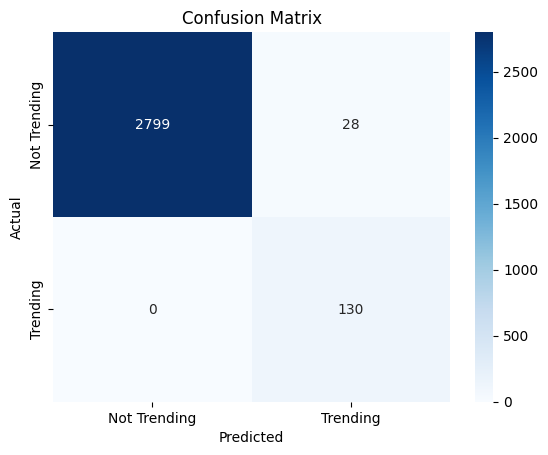

PR-AUC: 0.9346

--- Evaluating Balanced Random Forest ---


C:\Users\Laptop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\Laptop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\Laptop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imble

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2827
           1       0.99      0.99      0.99       130

    accuracy                           1.00      2957
   macro avg       1.00      1.00      1.00      2957
weighted avg       1.00      1.00      1.00      2957



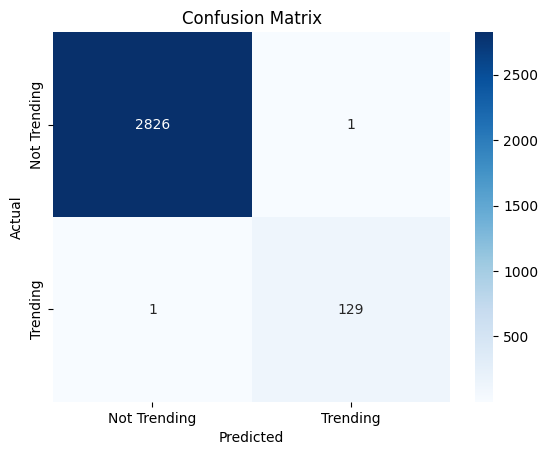

PR-AUC: 0.9999

--- Evaluating XGBoost ---


C:\Users\Laptop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2827
           1       1.00      0.99      1.00       130

    accuracy                           1.00      2957
   macro avg       1.00      1.00      1.00      2957
weighted avg       1.00      1.00      1.00      2957



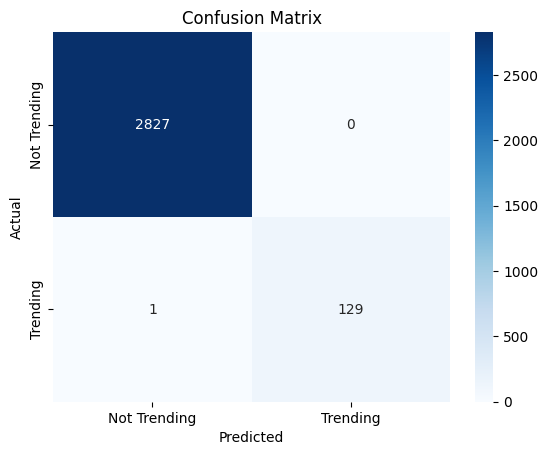

PR-AUC: 0.9993

--- Evaluating Support Vector Machine ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2827
           1       0.82      0.98      0.89       130

    accuracy                           0.99      2957
   macro avg       0.91      0.99      0.94      2957
weighted avg       0.99      0.99      0.99      2957



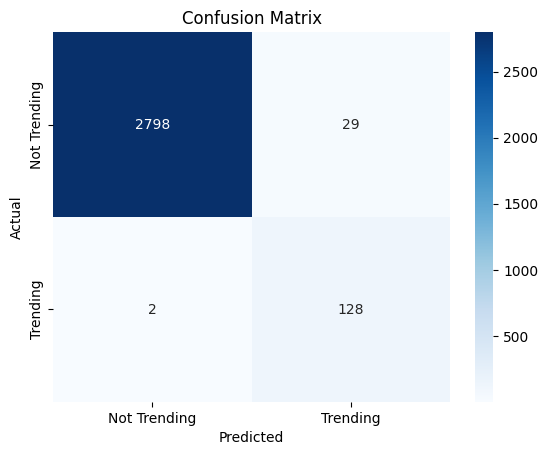

PR-AUC: 0.9598

--- Evaluating Neural Network ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2827
           1       0.92      0.98      0.95       130

    accuracy                           1.00      2957
   macro avg       0.96      0.99      0.97      2957
weighted avg       1.00      1.00      1.00      2957



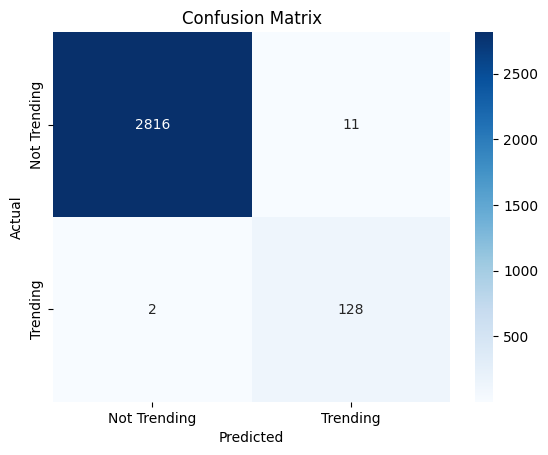

PR-AUC: 0.9917

Model Comparison (PR-AUC):
Logistic Regression: 0.9346
Balanced Random Forest: 0.9999
XGBoost: 0.9993
Support Vector Machine: 0.9598
Neural Network: 0.9917


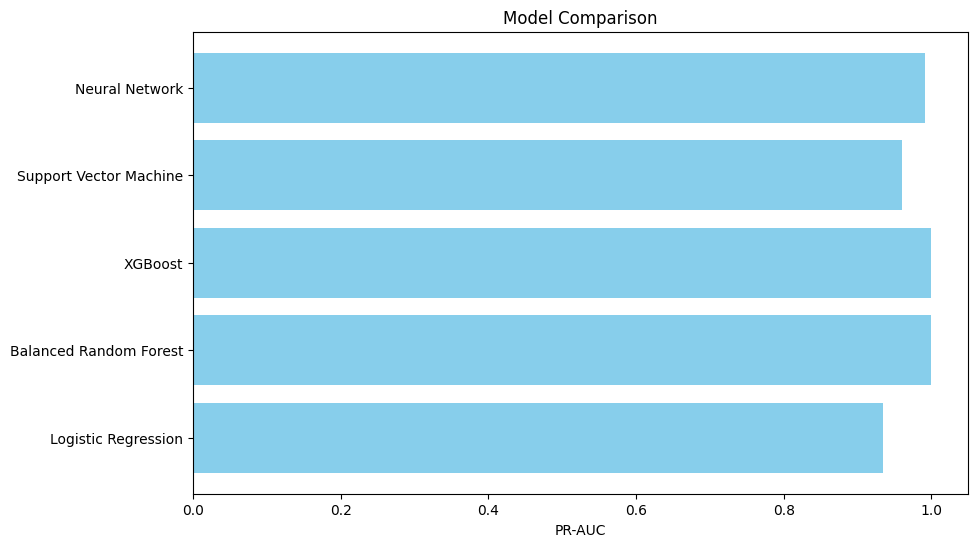

In [203]:
results = {}

# Fit and evaluate each model
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    model.fit(X_train_balanced, y_train_balanced)
    pr_auc = evaluate_model(model, X_test_preprocessed, y_test)
    results[name] = pr_auc

# Compare PR-AUC scores
print("\nModel Comparison (PR-AUC):")
for name, score in results.items():
    print(f"{name}: {score:.4f}")

# Plot PR-AUC comparison
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), list(results.values()), color="skyblue")
plt.xlabel("PR-AUC")
plt.title("Model Comparison")
plt.show()

In [138]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc

model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pr_auc_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Preprocess the data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Apply SMOTE to the training data
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_preprocessed, y_train)

    # Train and evaluate model
    model.fit(X_train_balanced, y_train_balanced)
    y_pred_proba = model.predict_proba(X_test_preprocessed)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    pr_auc_scores.append(pr_auc)

# Average PR-AUC over folds
print("Average PR-AUC:", np.mean(pr_auc_scores))


Average PR-AUC: 0.9673264018331821


Logistic regrssion hyperparameter tuning process

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score:  0.9963729828885418
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2827
           1       0.88      0.99      0.93       130

    accuracy                           0.99      2957
   macro avg       0.94      0.99      0.97      2957
weighted avg       0.99      0.99      0.99      2957



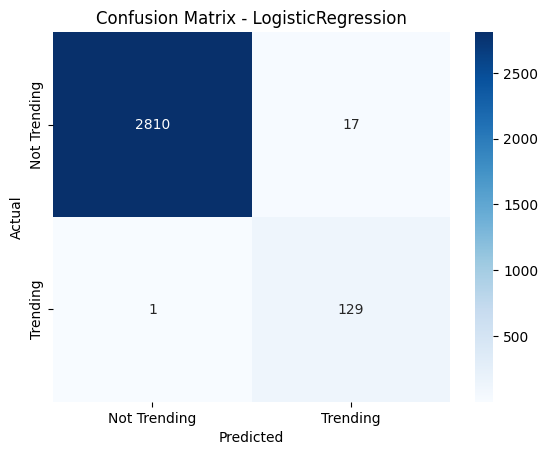

PR-AUC: 0.9384


0.938408553092597

In [205]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization types
    'solver': ['liblinear', 'saga']  # Solvers for l1 and l2
}

# Initialize the Logistic Regression model
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
grid_search.fit(X_train_balanced, y_train_balanced)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Fit the best model on the test set
best_logreg = grid_search.best_estimator_
evaluate_model(best_logreg, X_test_preprocessed, y_test)


We test on the best hyperparameters of our logistic regression model

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2827
           1       0.88      0.99      0.93       130

    accuracy                           0.99      2957
   macro avg       0.94      0.99      0.96      2957
weighted avg       0.99      0.99      0.99      2957



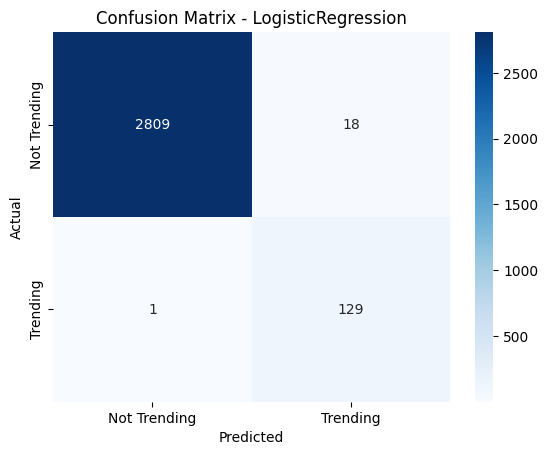

PR-AUC: 0.9354
Model saved as 'best_logreg_model.pkl'


In [ ]:
#Best parameters found:  {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Define the model with the best parameters
best_logreg = LogisticRegression(C=100, penalty='l1', solver='liblinear', class_weight='balanced', random_state=42, max_iter=1000)

# Train the model
best_logreg.fit(X_train_balanced, y_train_balanced)

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Trending', 'Trending'], yticklabels=['Not Trending', 'Trending'])
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.4f}")

    return pr_auc

# Evaluate the best model
evaluate_model(best_logreg, X_test_preprocessed, y_test)

# Save the model to a file using joblib
with open('best_logreg_model.pkl', 'wb') as file:
    pickle.dump(best_logreg, file)
print("Model saved as 'best_logreg_model.pkl'")


Neural Network hyperparameter tuning process

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for MLP:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Best cross-validation score:  0.9983192103370179
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2827
           1       0.92      0.98      0.95       130

    accuracy                           1.00      2957
   macro avg       0.96      0.99      0.97      2957
weighted avg       1.00      1.00      1.00      2957



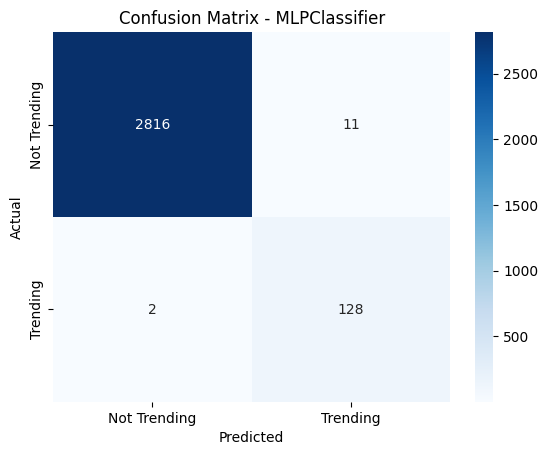

PR-AUC: 0.9917


0.9916882979173858

In [210]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for MLPClassifier
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Number of neurons in layers
    'activation': ['relu', 'tanh'],  # Activation functions
    'solver': ['adam'],  # Optimization algorithms
    'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    'learning_rate': ['constant', 'adaptive']  # Learning rate schedule
}

# Initialize the MLPClassifier
mlp = MLPClassifier(max_iter=1000, random_state=42)

# Perform GridSearchCV
mlp_grid_search = GridSearchCV(estimator=mlp, param_grid=mlp_param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
mlp_grid_search.fit(X_train_balanced, y_train_balanced)

# Best parameters and score
print("Best parameters for MLP: ", mlp_grid_search.best_params_)
print("Best cross-validation score: ", mlp_grid_search.best_score_)

# Fit the best model and evaluate
best_mlp = mlp_grid_search.best_estimator_
evaluate_model(best_mlp, X_test_preprocessed, y_test)


We test our best hyperparameters on our Neural Network model and save it to file for demo

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2827
           1       0.92      0.98      0.95       130

    accuracy                           1.00      2957
   macro avg       0.96      0.99      0.97      2957
weighted avg       1.00      1.00      1.00      2957



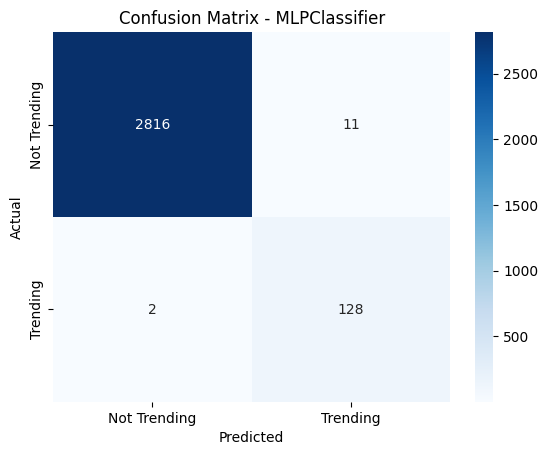

PR-AUC: 0.9917
Model saved as 'best_mlp_model.pkl'


In [213]:
#Best parameters for MLP:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}

# Define the model with the best parameters
best_mlp = MLPClassifier(
    activation='relu', #activation fuction
    alpha=0.0001, #regularization
    hidden_layer_sizes=(100,), #hidden layers
    learning_rate='constant', #learning rate
    solver='adam', #
    max_iter=1000, 
    random_state=42
)

# Train the model
best_mlp.fit(X_train_balanced, y_train_balanced)

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Trending', 'Trending'], yticklabels=['Not Trending', 'Trending'])
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.4f}")

    return pr_auc

# Evaluate the best model
evaluate_model(best_mlp, X_test_preprocessed, y_test)

# Save the model to a file using pickle
with open('best_mlp_model.pkl', 'wb') as file:
    pickle.dump(best_mlp, file)
print("Model saved as 'best_mlp_model.pkl'")


Hyperparameter tuning process for SupportVectorMachine

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVC:  {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation score:  0.9970364648496215
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2827
           1       0.90      0.98      0.94       130

    accuracy                           0.99      2957
   macro avg       0.95      0.99      0.97      2957
weighted avg       0.99      0.99      0.99      2957



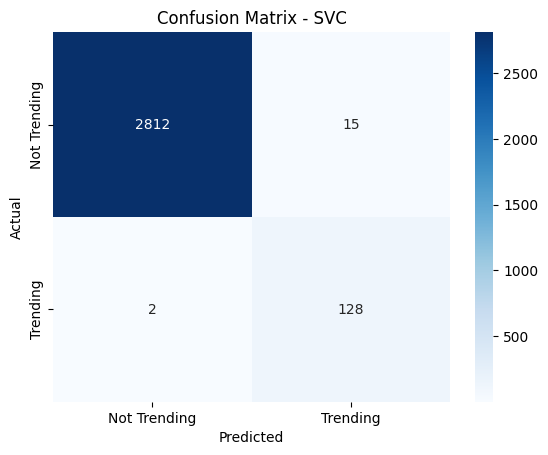

PR-AUC: 0.9475


0.9474738322484808

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for SVC
svc_param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [2]  # Degree for 'poly' kernel (if applicable)
}

# Initialize the SVC
svc = SVC(class_weight='balanced', probability=True, random_state=42)

# Perform GridSearchCV
svc_grid_search = GridSearchCV(estimator=svc, param_grid=svc_param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
svc_grid_search.fit(X_train_balanced, y_train_balanced)

# Best parameters and score
print("Best parameters for SVC: ", svc_grid_search.best_params_)
print("Best cross-validation score: ", svc_grid_search.best_score_)

# Fit the best model and evaluate
best_svc = svc_grid_search.best_estimator_
evaluate_model(best_svc, X_test_preprocessed, y_test)


Test on best hyperparameters and save the model for demonstration

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2827
           1       0.90      0.98      0.94       130

    accuracy                           0.99      2957
   macro avg       0.95      0.99      0.97      2957
weighted avg       0.99      0.99      0.99      2957



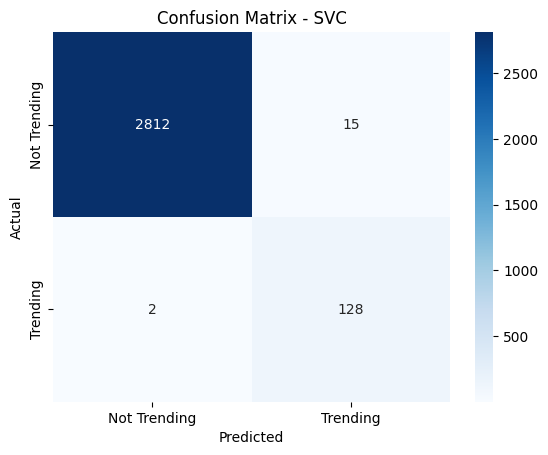

PR-AUC: 0.9475
Model saved as 'best_svc_model.pkl'


In [211]:
import pickle
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Define the model with the best parameters
best_svc = SVC(C=10, degree=2, gamma='scale', kernel='poly', class_weight='balanced', probability=True, random_state=42)

# Train the model
best_svc.fit(X_train_balanced, y_train_balanced)

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Trending', 'Trending'], yticklabels=['Not Trending', 'Trending'])
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.4f}")

    return pr_auc

# Evaluate the best model
evaluate_model(best_svc, X_test_preprocessed, y_test)

# Save the model to a file using pickle
with open('best_svc_model.pkl', 'wb') as file:
    pickle.dump(best_svc, file)
print("Model saved as 'best_svc_model.pkl'")


Hyperparameter tuning process for Random foreset

Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\Laptop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\Laptop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\Laptop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imble

Best parameters for Random Forest:  {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score:  0.9998673055643519
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2827
           1       1.00      0.99      1.00       130

    accuracy                           1.00      2957
   macro avg       1.00      1.00      1.00      2957
weighted avg       1.00      1.00      1.00      2957



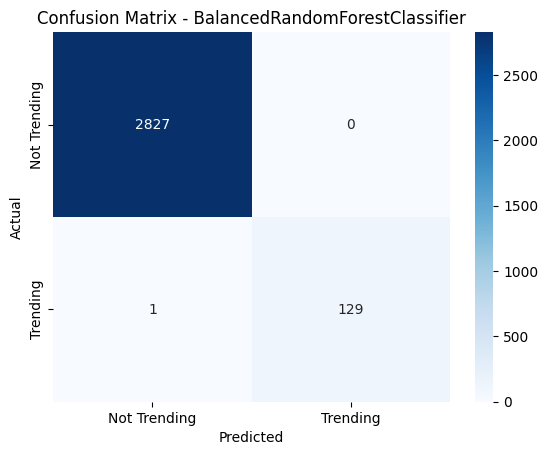

PR-AUC: 0.9999


0.9999410542481594

In [214]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for Balanced Random Forest
rf_param_grid = {
    'n_estimators': [50, 100],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'class_weight': ['balanced']  # Class weighting
}

# Initialize the BalancedRandomForestClassifier
rf = BalancedRandomForestClassifier(random_state=42)

# Perform GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
rf_grid_search.fit(X_train_balanced, y_train_balanced)

# Best parameters and score
print("Best parameters for Random Forest: ", rf_grid_search.best_params_)
print("Best cross-validation score: ", rf_grid_search.best_score_)

# Fit the best model and evaluate
best_rf = rf_grid_search.best_estimator_
evaluate_model(best_rf, X_test_preprocessed, y_test)

Test the best hyperparameter and save the model for demonstration

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2827
           1       1.00      0.99      1.00       130

    accuracy                           1.00      2957
   macro avg       1.00      1.00      1.00      2957
weighted avg       1.00      1.00      1.00      2957



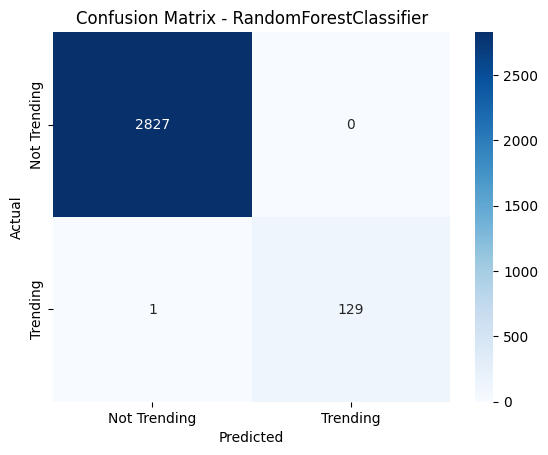

PR-AUC: 0.9999
Model saved as 'best_rf_model.pkl'


In [215]:
# Define the Random Forest model with the best parameters
best_rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

# Train the model
best_rf.fit(X_train_balanced, y_train_balanced)

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Trending', 'Trending'], yticklabels=['Not Trending', 'Trending'])
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.4f}")

    return pr_auc

# Evaluate the best model
evaluate_model(best_rf, X_test_preprocessed, y_test)

# Save the model to a file using pickle
with open('best_rf_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)
print("Model saved as 'best_rf_model.pkl'")
